# VWAP v1 - Schedule Factor
_Version 1.0_

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# load our helper functios
import simtools as st
import vwap1 as vw

matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )

### Load TAQ Data

We'll assume we have already done some cleaning by using our Tick Data Setup or similar code

In [2]:
# set up some variables
tickfile = '../data/TSLA-TAQ-aug19v2.zip'
test_day = '2019-08-30'
taq = pd.read_pickle(tickfile)
taq

,exch,bid_px,bid_size,ask_px,ask_size,qu_cond,qu_seqnum,natbbo_ind,qu_cancel,qu_source,symbol,suffix_x,suffix_y,trade_size,trade_px
2019-08-01 09:30:00.221856542,A,241.34,1.0,243.33,1.0,R,943492.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-01 09:30:00.393481242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TSLA,NaN,NaN,10.0,242.045
2019-08-01 09:30:00.415319200,C,240.88,1.0,243.78,1.0,R,946592.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-01 09:30:00.415596052,N,241.34,1.0,243.33,1.0,R,946597.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-01 09:30:00.694857858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TSLA,NaN,NaN,5.0,242.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30 15:59:59.991016490,Z,225.55,1.0,225.62,1.0,R,43972280.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-30 15:59:59.991034985,Z,225.56,1.0,225.62,1.0,R,43972281.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-30 15:59:59.991902659,Z,225.56,1.0,225.62,2.0,R,43972301.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-30 15:59:59.993930363,Z,225.56,1.0,225.62,1.0,R,43972342.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN


In [3]:
# filter on date
day = taq[test_day]
day

,exch,bid_px,bid_size,ask_px,ask_size,qu_cond,qu_seqnum,natbbo_ind,qu_cancel,qu_source,symbol,suffix_x,suffix_y,trade_size,trade_px
2019-08-30 09:30:00.000435733,K,229.00,11.0,230.00,12.0,R,690866.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-30 09:30:00.000507173,Z,229.40,1.0,230.50,4.0,R,690872.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-30 09:30:00.001223950,Q,229.00,19.0,229.79,3.0,R,690898.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-30 09:30:00.139723704,Z,229.40,1.0,230.50,4.0,R,694075.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-30 09:30:00.139732326,Z,229.40,1.0,230.50,4.0,R,694076.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30 15:59:59.991016490,Z,225.55,1.0,225.62,1.0,R,43972280.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-30 15:59:59.991034985,Z,225.56,1.0,225.62,1.0,R,43972281.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-30 15:59:59.991902659,Z,225.56,1.0,225.62,2.0,R,43972301.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN
2019-08-30 15:59:59.993930363,Z,225.56,1.0,225.62,1.0,R,43972342.0,0.0,NaN,N,TSLA,NaN,NaN,NaN,NaN


## VWAP Target Function

In [4]:
vwap_coefs = [ 6.82705253e-03, -4.98952946e-05,  2.47593111e-07, -6.04833777e-10, 5.78006232e-13]

## Run the Algo

In [5]:
order_quantity = 250000
order_side = 'b'
results = vw.algo_loop(day, order_side, order_quantity, vwap_coefs)

2020-03-28 16:03:15:784097: Beginning VWAP run: b 250000 shares
Average stock spread for sample: 1.3625
2020-03-28 16:03:15:991245: starting main loop
2020-03-28 16:06:04:974483: end simulation loop
2020-03-28 16:06:04:975467: order analytics
2020-03-28 16:06:05:080540: VWAP run complete.


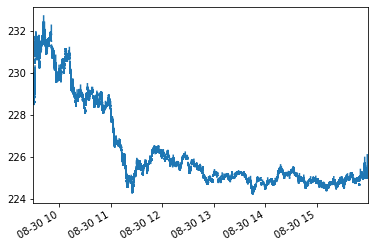

In [9]:
results['fair_values'].plot()
plt.show()

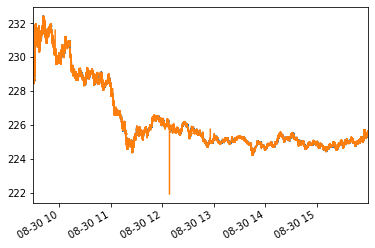

In [10]:
results['midpoints'].plot()
day.trade_px.plot()
plt.show()

In [13]:
data = results['trades']
data

,price,shares,bar,trade_type
2019-08-30 09:31:00.717796461,228.78,1700,1,a
2019-08-30 09:31:08.372103712,228.54,100,1,p
2019-08-30 09:32:00.000806860,229.95,1600,2,a
2019-08-30 09:32:00.000956550,229.63,200,2,p
2019-08-30 09:33:00.032543152,231.58,1400,3,a
...,...,...,...,...
2019-08-30 15:58:00.075605858,225.33,1000,388,a
2019-08-30 15:58:00.086391141,225.35,1000,388,a
2019-08-30 15:58:00.160745464,225.4,20,388,p
2019-08-30 15:59:00.011097494,225.44,5400,389,a


In [14]:
data[pd.notna(data.price)]['shares'].sum()

250138.0

## Statistics

We'll put various metrics here, depending on what our algo is doing. For now we'll just put some basic order counts.

In [15]:
results.keys()

dict_keys(['midpoints', 'fair_values', 'schedule_factors', 'trades', 'quote_count', 'day_vwap', 'avg_price', 'order_targets'])

In [16]:
results['day_vwap']

227.90490596599633

In [17]:
results['avg_price']

227.02264725871308

In [18]:
#slippage vs. vwap
results['day_vwap'] - results['avg_price']

0.8822587072832562

In [19]:
results['trades'].groupby(['trade_type']).count()

,price,shares,bar
trade_type,,,
a,389,389,389
p,379,379,379
